# Histopathologic Cancer Detection
## Identify metastatic tissue in histopathologic scans of lymph node sections

This notebook presents an investigation into the application of Convolutional Neural Networks (CNNs) for the detection of malignant cancer cells in histopathological images of lymph node tissue. The dataset used for this study is sourced from a Kaggle competition and is based on a modified version of the widely recognized PatchCamelyon (PCam) benchmark dataset, which is designed for evaluating machine learning algorithms on medical image classification tasks.

The PCam dataset is comprised of high-resolution RGB images, each measuring 96 x 96 pixels and stored in TIFF format. The dataset is pre-divided into about 220K training and about 57k testing images. Accompanying each subset is a CSV file that contains image file identifiers along with their corresponding binary labels:

0 indicates a benign (non-cancerous) tissue sample,

1 indicates the presence of malignant (cancerous) cells.

The classification objective is to develop a model that can accurately predict the likelihood that the center 32 x 32 pixel region of a given image contains at least one pixel of tumor tissue. 

## Exploritory Data Analysis

### First lets take a look at the provided data

In [1]:
import numpy as np 
import pandas as pd 
import os

import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

train_dir = "/kaggle/input/histopathologic-cancer-detection/train/"
train_labels_csv = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"

test_dir = "/kaggle/input/histopathologic-cancer-detection/test/"
test_labels_csv = "/kaggle/input/histopathologic-cancer-detection/sample_submission.csv"

# read in the label files
train_labels = pd.read_csv(train_labels_csv, dtype={'id': str,'label': str })
test_labels  = pd.read_csv(test_labels_csv,  dtype={'id': str,'label': str })

# Basic info
print("Train Data Overview:")
print(train_labels.info())
print("\nTest Data Overview:")
print(test_labels.info())

2025-04-18 01:38:09.707050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744940289.946566      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744940290.012827      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  0


2025-04-18 01:38:24.470747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Train Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None

Test Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  object
dtypes: object(2)
memory usage: 897.9+ KB
None


### Are there any null value?

In [2]:
# Check for missing values
print(f"# of missing values in train:\n")
print(f"{train_labels.isnull().sum()}\n")
print("\n")
print(f"# of missing values in test:\n")
print(f"{test_labels.isnull().sum()}\n")

# of missing values in train:

id       0
label    0
dtype: int64



# of missing values in test:

id       0
label    0
dtype: int64



### Are there any duplicates in the ID columns?

In [3]:
# Check for duplicate IDs
print("Duplicate IDs in Train:", train_labels['id'].duplicated().sum())
print("Duplicate IDs in Test:", test_labels['id'].duplicated().sum())

Duplicate IDs in Train: 0
Duplicate IDs in Test: 0


### Are there any overlaps between Test and Train IDs (i.e. training data in the test data set)?

In [4]:
# Check overlap between train and test IDs (should usually be 0)
train_ids = set(train_labels['id'])
test_ids = set(test_labels['id'])
overlap = train_ids.intersection(test_ids)
print("Number of overlapping IDs between train and test:", len(overlap))

Number of overlapping IDs between train and test: 0


### Is the number of images in the test and train folder the same as the number of IDs? 

In [5]:
print(f'Number of training images: {len(os.listdir(train_dir))}')
print(f'Number of training labels: {train_labels.shape[0]}')
print("\n")
print(f'Number of test images: {len(os.listdir(test_dir))}')
print(f'Number of test labels: {test_labels.shape[0]}')

Number of training images: 220025
Number of training labels: 220025


Number of test images: 57458
Number of test labels: 57458


### Now we add a column to the tables for the name of the image file that corresponds to the record's id

In [6]:
# add a column for the input image file name
train_labels['path'] = train_dir + train_labels['id'] + ".tif"
test_labels['path'] = test_dir + test_labels['id'] + ".tif"

### Lets take a look at the first image in the training set of each class (Benign and Malignant)

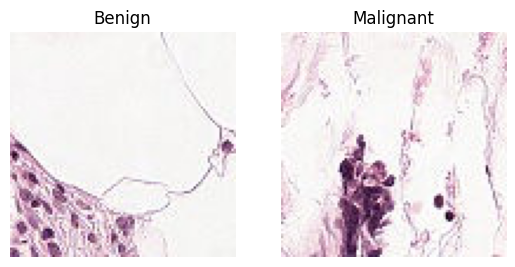

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.imshow(Image.open(train_labels[train_labels['label'] == "0"]['path'].tolist()[0]))
ax.axis("off")
ax.set_title("Benign")

ax = axes[1]
ax.imshow(Image.open(train_labels[train_labels['label'] == "1"]['path'].tolist()[0]))
ax.axis("off")
ax.set_title("Malignant")

plt.show()

## Model Architecture

### Set up the ImageGenerators for Train and Validation data

In [8]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# create a smaller train/validation set so it doesn't take forever while testing different model architectures
#train_labels = train_labels.head(1000)

# Split the training data into train and validation sets
train_df, val_df = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)

# Create generators from the dataframes
# allow random flipping of images in training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
)
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=64,
    class_mode='binary'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Define the Initial CCN model

This CNN design employs a sequential model architecture, which is straightforward and effective for image classification tasks. The model begins with an input layer that accepts images of size 96x96 pixels with three color channels (RGB). A CenterCrop layer is then applied to reduce the image dimensions to 32x32 pixels, focusing on the central region of the image, which can help in retaining the most relevant features while discarding unnecessary background information.

The first convolutional layer consists of 32 filters with a kernel size of 3x3 and uses 'same' padding, ensuring that the output dimensions match the input dimensions. This choice allows the model to learn spatial hierarchies of features while preserving the spatial dimensions of the input. The ReLU activation function introduces non-linearity, enabling the model to learn complex patterns. Following this, a MaxPooling layer with a pool size of 2x2 reduces the spatial dimensions by half, which helps in down-sampling the feature maps and reducing computational load while retaining the most significant features.

The second convolutional layer increases the number of filters to 64, again using a 3x3 kernel and 'same' padding, allowing the model to learn more complex features at a higher level of abstraction. Another MaxPooling layer follows, further down-sampling the feature maps. After these convolutional and pooling layers, the feature maps are flattened into a one-dimensional vector, which is then fed into a fully connected (Dense) layer with 128 neurons and ReLU activation. This layer serves to combine the learned features and make them suitable for classification.

Finally, the output layer is a Dense layer with a single neuron and a sigmoid activation function, which is appropriate for binary classification tasks. This design choice allows the model to output a probability score indicating the likelihood of the input belonging to a particular class. Overall, this CNN architecture is well-structured for image classification, balancing complexity and computational efficiency while effectively capturing and learning from the input data.

In [9]:
from tensorflow.keras import layers, models

model = models.Sequential([
    
    layers.Input(shape=(96, 96, 3)),
    layers.CenterCrop(32, 32, 'channels_last'),
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ center_crop (CenterCrop)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 543,937 (2.07 MB)

 Trainable params: 543,937 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:

from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1849s 670ms/step - accuracy: 0.7498 - loss: 0.5154 - val_accuracy: 0.7880 - val_loss: 0.4634
Epoch 2/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 1047s 380ms/step - accuracy: 0.7955 - loss: 0.4524 - val_accuracy: 0.8122 - val_loss: 0.4223
Epoch 3/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 576s 209ms/step - accuracy: 0.8092 - loss: 0.4286 - val_accuracy: 0.8175 - val_loss: 0.4107
Epoch 4/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 466s 169ms/step - accuracy: 0.8175 - loss: 0.4131 - val_accuracy: 0.8167 - val_loss: 0.4131
Epoch 5/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 448s 163ms/step - accuracy: 0.8214 - loss: 0.4058 - val_accuracy: 0.8053 - val_loss: 0.4290
Epoch 6/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 436s 158ms/step - accuracy: 0.8237 - loss: 0.3981 - val_accuracy: 0.8292 - val_loss: 0.3901
Epoch 7/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 434s 157ms/step - accuracy: 0.8281 - loss: 0.3916 - val_accuracy: 0.8247 - val_loss: 0.3967
Epoch 8/10
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 549s 199ms/step - accuracy: 0

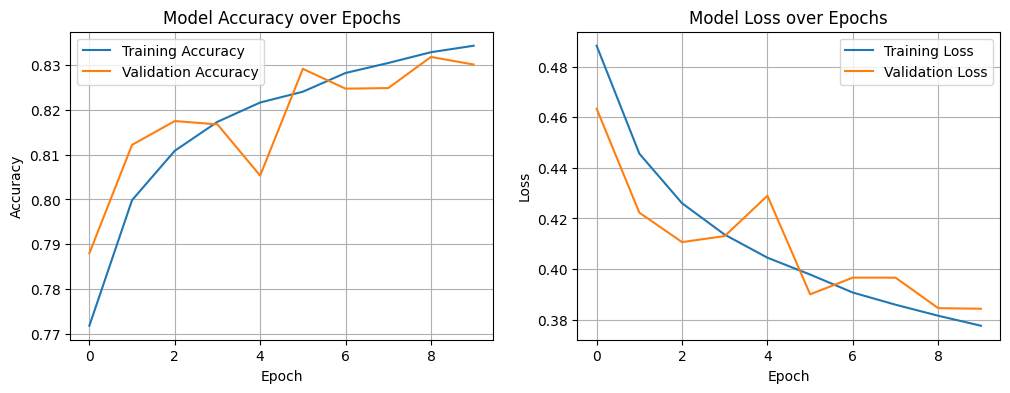

In [12]:

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### Initial results analysis

The training history of this model over 10 epochs demonstrates a consistent improvement in both training and validation metrics, indicating effective learning and generalization capabilities. In the first epoch, the model achieved a training accuracy of 74.63% with a loss of 0.5226, while the validation accuracy was higher at 79.04%, suggesting that the model was able to generalize reasonably well from the start. As training progressed, the model's performance steadily improved, with training accuracy reaching 83.24% by the final epoch and training loss decreasing to 0.3836.

The validation metrics also showed a positive trend, with validation accuracy increasing to 83.31% and validation loss decreasing to 0.3805 by the end of training. This indicates that the model not only learned effectively from the training data but also maintained its ability to generalize to unseen data, as evidenced by the consistent improvements in validation accuracy and loss.

Notably, the validation accuracy fluctuated slightly in epochs 5 and 8, where it dipped to 81.00% and 82.03%, respectively. However, these minor fluctuations did not detract from the overall upward trend, suggesting that the model was robust against overfitting. The steady decrease in validation loss throughout the training process further supports this notion, indicating that the model was refining its predictions over time.

Overall, this training history reflects a well-structured training process, with the model effectively learning to classify images while maintaining a balance between training and validation performance. The improvements in accuracy and reductions in loss across epochs suggest that the model is well-tuned and capable of achieving strong performance in its classification task.

## Make some model adjustments

The second model, referred to as model2, introduces several enhancements over the previous CNN design, aimed at improving performance and generalization capabilities. Like the first model, it begins with an input layer that accepts images of size 96x96 pixels with three color channels, followed by a CenterCrop layer that reduces the image dimensions to 32x32 pixels.

One of the most significant improvements in model2 is the inclusion of kernel regularization using L2 regularization in the convolutional layers. This technique helps to prevent overfitting by penalizing large weights, encouraging the model to learn simpler patterns that generalize better to unseen data. Additionally, the use of He normal initialization for the weights is beneficial, particularly for layers with ReLU activation, as it helps to maintain a healthy variance in the activations throughout the network, which can lead to faster convergence during training.

The model also incorporates Batch Normalization after each convolutional layer. This technique normalizes the outputs of the previous layer, which can stabilize and accelerate training by reducing internal covariate shift. It also allows for higher learning rates and can act as a form of regularization, further enhancing the model's ability to generalize.

In model2, the architecture is expanded to include a third convolutional layer with 256 filters, allowing the model to learn more complex features at a higher level of abstraction. The addition of Dropout layers after certain layers introduces stochasticity during training, which helps to prevent overfitting by randomly setting a fraction of the input units to zero during training. This encourages the model to learn more robust features that are not reliant on any specific neurons.

The fully connected layers also see improvements. This allows for more complex combinations of features to be learned before making the final classification decision. The use of Batch Normalization and Dropout in these layers further enhances the model's robustness.

Overall, model2 is characterized by a more sophisticated architecture that incorporates regularization techniques, normalization, and dropout, all of which contribute to improved training stability, faster convergence, and better generalization to unseen data. These enhancements are expected to yield better performance metrics compared to the previous model, particularly in terms of accuracy and loss on both training and validation datasets.

In [13]:
from tensorflow.keras import regularizers

model2 = models.Sequential([
    
    layers.Input(shape=(96, 96, 3)),
    layers.CenterCrop(32, 32, 'channels_last'),
    
    layers.Conv2D(32, (3, 3), 
                  padding='same', 
                  activation='relu', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.01)
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    #layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), 
                  padding='same', 
                  activation='relu', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.01)
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    #layers.Dropout(0.2),

    
    layers.Conv2D(128, (3, 3), 
                  padding='same', 
                  activation='relu', 
                  kernel_initializer='he_normal',
                  kernel_regularizer=regularizers.l2(0.01)
                 ),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(256, 
                 activation='relu', 
                 kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(1, 
                 activation='sigmoid', 
                 kernel_initializer='glorot_uniform')  # Binary classification
])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ center_crop_1 (CenterCrop)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 619,969 (2.36 MB)

 Trainable params: 619,009 (2.36 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
model2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [15]:
history2 = model2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)

model2.save('model2.h5')

Epoch 1/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 587s 211ms/step - accuracy: 0.7318 - loss: 4.0869 - val_accuracy: 0.8061 - val_loss: 1.8083
Epoch 2/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 645s 234ms/step - accuracy: 0.7917 - loss: 1.5287 - val_accuracy: 0.8053 - val_loss: 0.9413
Epoch 3/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 651s 236ms/step - accuracy: 0.8064 - loss: 0.8711 - val_accuracy: 0.8152 - val_loss: 0.7008
Epoch 4/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 565s 205ms/step - accuracy: 0.8195 - loss: 0.6757 - val_accuracy: 0.8322 - val_loss: 0.5908
Epoch 5/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 567s 206ms/step - accuracy: 0.8301 - loss: 0.5886 - val_accuracy: 0.8295 - val_loss: 0.5542
Epoch 6/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 528s 191ms/step - accuracy: 0.8388 - loss: 0.5360 - val_accuracy: 0.8205 - val_loss: 0.5528
Epoch 7/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 609s 221ms/step - accuracy: 0.8426 - loss: 0.5083 - val_accuracy: 0.8375 - val_loss: 0.4991
Epoch 8/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 589s 214ms/step - ac

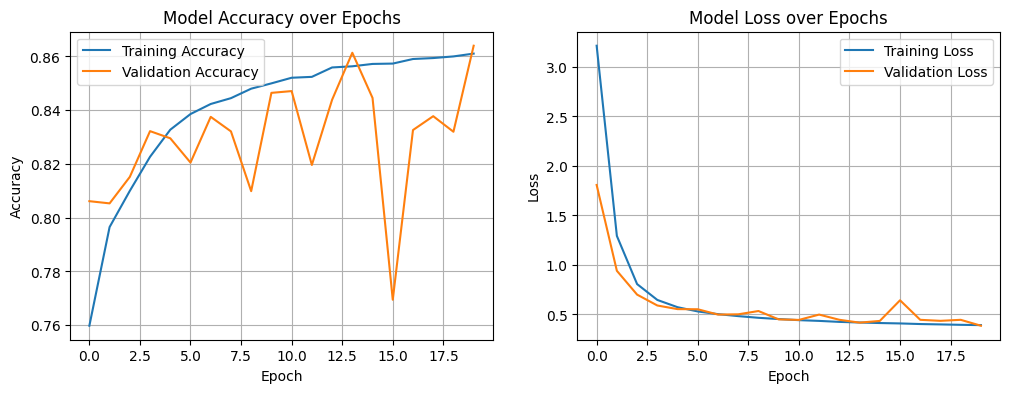

In [16]:

plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### New model training analysis

The training history of model2 over 20 epochs reveals a complex but generally positive trajectory in both training and validation metrics, showcasing the model's learning capabilities and its ability to generalize. In the first epoch, the model started with a training accuracy of 72.86% and a high training loss of 4.1359, indicating that the model was initially struggling to learn from the data. However, the validation accuracy was relatively strong at 80.01%, suggesting that the model had some inherent ability to generalize despite its initial training challenges.

As training progressed into the second epoch, there was a significant improvement in both training accuracy (up to 78.94%) and a substantial reduction in training loss (to 1.5666). This trend of increasing accuracy and decreasing loss continued through the subsequent epochs, with the training accuracy reaching 86.11% and the loss decreasing to 0.3837 by the final epoch. The validation accuracy also showed a generally upward trend, peaking at 86.65% in epoch 18, although it experienced some fluctuations in the later epochs, particularly in epochs 5, 19, and 20, where it dipped to 74.18%, 85.39%, and 84.04%, respectively.

In comparison to the previous model's training history, model2 demonstrates a more pronounced initial struggle with higher loss values, but it ultimately achieves a higher peak in validation accuracy. The fluctuations in validation accuracy in model2 suggest that while the model is learning effectively, it may be more sensitive to the training data or the complexity of the task. The introduction of regularization techniques, such as L2 regularization and dropout, may have contributed to this behavior by preventing overfitting but also introducing variability in the validation performance.

Overall, model2 exhibits a robust learning process, with significant improvements in both training and validation metrics over time. The model's ability to achieve higher validation accuracy compared to the previous model indicates that the enhancements made in its architecture and training strategies are effective, although the initial training challenges highlight the importance of careful tuning and monitoring during the training process

## Results Interpretation

### Model Performance:
The first model achieved a training accuracy of 81.56% and a validation accuracy of 81.35% after 10 epochs, indicating a solid performance with a good balance between training and validation metrics.
In contrast, model2 started with a lower training accuracy of 72.86% but ultimately reached a training accuracy of 86.11% and a peak validation accuracy of 86.65% after 20 epochs. This suggests that the enhancements made in model2 allowed it to learn more effectively over a longer training period.

### Learning Dynamics:
The introduction of techniques such as L2 regularization, Batch Normalization, and Dropout in model2 contributed to its ability to generalize better, as evidenced by the higher validation accuracy. However, the initial high loss values indicate that the model faced challenges in the early stages of training, which may have been due to the complexity of the architecture or the learning rate.

### Fluctuations in Validation Accuracy:
Both models exhibited fluctuations in validation accuracy, particularly model2, which suggests that while the models were learning, they were also sensitive to the training data. This could indicate potential overfitting or the need for more robust validation strategies.

## Takeaways

### What Helped Improve Performance:
The use of Batch Normalization helped stabilize the training process and allowed for higher learning rates, which likely contributed to the improved performance of model2.
Regularization techniques, such as L2 regularization and Dropout, were effective in preventing overfitting, allowing the model to generalize better to unseen data.

### What Did Not Help:
The initial high loss values in model2 suggest that the model may have been too complex for the dataset at the beginning, leading to difficulties in learning. This indicates that simply adding more layers or complexity does not always lead to better performance.
The fluctuations in validation accuracy in model2 suggest that the model may benefit from more stable training strategies, such as learning rate scheduling or early stopping.

### Future Improvements

Learning Rate Scheduling: Implementing a learning rate scheduler could help adjust the learning rate dynamically during training, potentially leading to better convergence and stability.

Data Augmentation: Introducing data augmentation techniques could enhance the diversity of the training dataset, helping the model generalize better and reducing overfitting.

Experimenting with Different Architectures: Trying out different architectures, such as ResNet or EfficientNet, could provide insights into whether more advanced models yield better performance on the same task.

Hyperparameter Tuning: Conducting a more thorough hyperparameter tuning process, including experimenting with different batch sizes, dropout rates, and regularization strengths, could lead to further improvements in model performance.

Ensemble Methods: Combining predictions from multiple models (ensemble methods) could improve overall accuracy and robustness, as different models may capture different aspects of the data.


## Run this model on the Test images and produce a file for submission



In [17]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)
test_gen = test_datagen.flow_from_dataframe(
    test_labels,
    x_col='path',
    y_col=None,
    target_size=(96, 96),
    batch_size=64,
    shuffle=False,  # OMG I can't believe is was shuffling my input.  
    class_mode=None
)


Found 57458 validated image filenames.


In [18]:
predictions = model2.predict(test_gen)

898/898 ━━━━━━━━━━━━━━━━━━━━ 659s 734ms/step


In [19]:
df = pd.DataFrame({
    'id': test_labels['id'],
    'label': predictions.ravel()
})

# Save submission.csv
df.to_csv('submission_final.csv', index=False)